In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

import csv
import json
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2

from sklearn.metrics import classification_report

In [ ]:
# Load CIFAR-100 data  https://www.cs.toronto.edu/%7Ekriz/cifar.html
#Each image has a "fine" label (class) and a "coarse" label (superclass).
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# normalize pixel values
x_train, x_test = x_train/255, x_test/255

y_train_raw = y_train.copy()

#one hot encode labels
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

169001437/169001437 [==============================] - 13s 0us/step


In [ ]:
def model_performance(history):
        # Plots
        plt.figure(figsize=(20, 4))

        # plot accuracy
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend()

        # plot loss
        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # plot learning rate changes
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Changes')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Training Data
        final_train_accuracy = history.history['accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        print('Training Performance:')
        print(f"Accuracy: {round(final_train_accuracy*100, 2)}%")
        print(f"Loss: {round(final_train_loss, 4)}")

        # Validation Data
        final_val_accuracy = history.history['val_accuracy'][-1]
        final_val_loss = history.history['val_loss'][-1]
        print('\nValidation Performance:')
        print(f"Accuracy: {round(final_val_accuracy*100, 2)}%")
        print(f"Loss: {round(final_val_loss, 4)}")

Altered function to save both datagen and callbacks by model ID in addition to model architecture



In [ ]:

# Altered function to save both datagen and callbacks by model ID

def save_model_info(model, model_id, optimizer, loss, filters, dropout_rate, kernel_size, pool_size, dense_units, history, datagen, callbacks):
    model_id = model_id

    # Define the base path
    base_path = '/content/drive/MyDrive/cifar100/'

    # Save model architecture to CSV
    with open(f'{base_path}model_architecture2.csv', 'a', newline='') as csvfile:
        fieldnames_architecture = ['model_id', 'architecture', 'config']
        writer_architecture = csv.DictWriter(csvfile, fieldnames=fieldnames_architecture)

        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer_architecture.writeheader()

        optimizer_config = optimizer.get_config()
        config = f"op: {optimizer_config['name']}, learning_rate: {optimizer_config['learning_rate']}, " \
                 f"l: {loss}, fltr: {filters}, dor: {dropout_rate}, ks: {kernel_size}, " \
                 f"ps: {pool_size}, du: {dense_units}"

        writer_architecture.writerow({
            'model_id': model_id,
            'architecture': model.to_json(),
            'config': config
        })

    # Save model performance to CSV
    with open(f'{base_path}model_performance2.csv', 'a', newline='') as csvfile:
        fieldnames_performance = ['model_id', 'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
        writer_performance = csv.DictWriter(csvfile, fieldnames=fieldnames_performance)

        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer_performance.writeheader()

        for epoch in range(1, len(history.history['accuracy']) + 1):
            writer_performance.writerow({
                'model_id': model_id,
                'epoch': epoch,
                'accuracy': history.history['accuracy'][epoch - 1],
                'loss': history.history['loss'][epoch - 1],
                'val_accuracy': history.history['val_accuracy'][epoch - 1],
                'val_loss': history.history['val_loss'][epoch - 1],
                'learning_rate': history.history.get('lr', [None])[epoch - 1]
            })

    # Save augmentation settings to CSV
    with open(f'{base_path}augmentation_settings.csv', 'a', newline='') as csvfile:
        fieldnames_augmentation = ['model_id', 'rotation_range', 'width_shift_range', 'height_shift_range', 'shear_range', 'zoom_range', 'horizontal_flip', 'fill_mode']
        writer_augmentation = csv.DictWriter(csvfile, fieldnames=fieldnames_augmentation)

        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer_augmentation.writeheader()

        writer_augmentation.writerow({
            'model_id': model_id,
            'rotation_range': datagen.rotation_range,
            'width_shift_range': datagen.width_shift_range,
            'height_shift_range': datagen.height_shift_range,
            'shear_range': datagen.shear_range,
            'zoom_range': datagen.zoom_range,
            'horizontal_flip': datagen.horizontal_flip,
            'fill_mode': datagen.fill_mode
        })


    with open(f'{base_path}callback_settings.csv', 'a', newline='') as csvfile:
        fieldnames_callback = ['model_id', 'callback', 'parameters']
        writer_callback = csv.DictWriter(csvfile, fieldnames=fieldnames_callback)

        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer_callback.writeheader()

        for callback in callbacks:
            if isinstance(callback, ReduceLROnPlateau):
                parameters = {
                    'monitor': callback.monitor,
                    'factor': callback.factor,
                    'patience': callback.patience,
                    'min_lr': callback.min_lr,
                    'verbose': callback.verbose
                }
            elif isinstance(callback, EarlyStopping):
                parameters = {
                    'monitor': callback.monitor,
                    'patience': callback.patience,
                    'restore_best_weights': callback.restore_best_weights,
                    'verbose': callback.verbose
                }
            else:
                parameters = {}

            writer_callback.writerow({
                'model_id': model_id,
                'callback': callback.__class__.__name__,
                'parameters': str(parameters)
            })


Image Augmentation

In [ ]:
# Original Project Image Augmentation

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
# )


In [ ]:
# Updated Image Augmentation

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

Original Model Architecture: Best Performing Overall

In [ ]:


# def CNN(op=optimizer, l=loss, fltr=filters, dor=dropout_rate, ks=kernel_size, ps=pool_size, du=dense_units):
#     m = models.Sequential()

#     m.add(layers.Conv2D(fltr, ks, activation='relu', input_shape=(32, 32, 3)))
#     m.add(layers.Conv2D(fltr, ks, activation='relu'))
#     m.add(layers.BatchNormalization())
#     m.add(layers.MaxPool2D(ps))
#     m.add(layers.Dropout(dor))


#     m.add(layers.Conv2D(2*fltr, ks, activation='relu'))
#     m.add(layers.BatchNormalization())
#     m.add(layers.Conv2D(2*fltr, ks, activation='relu'))
#     m.add(layers.BatchNormalization())
#     m.add(layers.MaxPool2D(ps))
#     m.add(layers.Dropout(dor))

#     m.add(layers.Conv2D(4*fltr, ks, activation='relu'))
#     m.add(layers.BatchNormalization())
#     m.add(layers.Conv2D(4*fltr, ks, activation='relu'))
#     m.add(layers.BatchNormalization())
#     m.add(layers.Dropout(dor))

#     m.add(layers.Flatten())
#     m.add(layers.Dense(du, activation='relu'))
#     m.add(layers.Dropout(dor))
#     m.add(layers.BatchNormalization())
#     m.add(layers.Dense(100, activation='softmax'))

#     m.compile(
#         optimizer = op,
#         loss = l,
#         metrics = ['accuracy']
#     )
#     return m

One of my earlier models from the tuning portion of the project.

Epoch 1/80
782/782 [==============================] - 36s 42ms/step - loss: 4.3060 - accuracy: 0.0574 - val_loss: 4.2502 - val_accuracy: 0.0651 - lr: 0.0010
Epoch 2/80
782/782 [==============================] - 33s 42ms/step - loss: 3.8627 - accuracy: 0.1043 - val_loss: 3.6985 - val_accuracy: 0.1378 - lr: 0.0010
Epoch 3/80
782/782 [==============================] - 33s 42ms/step - loss: 3.6677 - accuracy: 0.1345 - val_loss: 3.5068 - val_accuracy: 0.1539 - lr: 0.0010
Epoch 4/80
782/782 [==============================] - 33s 42ms/step - loss: 3.5168 - accuracy: 0.1615 - val_loss: 3.2753 - val_accuracy: 0.1987 - lr: 0.0010
Epoch 5/80
782/782 [==============================] - 33s 42ms/step - loss: 3.3727 - accuracy: 0.1845 - val_loss: 3.1721 - val_accuracy: 0.2283 - lr: 0.0010
Epoch 6/80
782/782 [==============================] - 33s 42ms/step - loss: 3.2584 - accuracy: 0.2057 - val_loss: 3.0290 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 7/80
782/782 [==============================] - 33s 

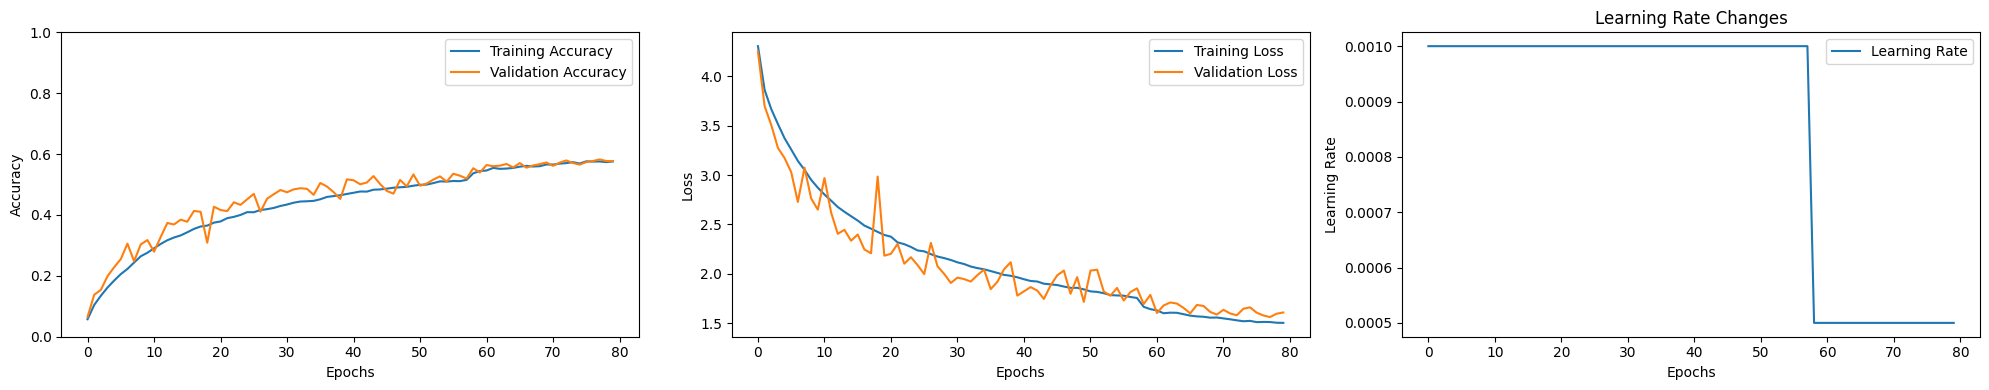

Training Performance:
Accuracy: 57.58%
Loss: 1.5013

Validation Performance:
Accuracy: 57.7%
Loss: 1.6068


In [ ]:

optimizer=optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'
filters = 64
dropout_rate = .2
kernel_size = (3,3)
pool_size = (2,2)
dense_units = 256

# # Model execution
epochs = 80
# steps_per_epoch = 100
batch_size = 64


# CNN Architecture
def CNN(op=optimizer, l=loss, fltr=filters, dor=dropout_rate, ks=kernel_size, ps=pool_size, du=dense_units):
    m = models.Sequential()

    m.add(layers.Conv2D(fltr, ks, activation='relu', input_shape=(32, 32, 3)))
    m.add(layers.Conv2D(2*fltr, ks, activation='relu'))
    m.add(layers.MaxPool2D(ps))

    m.add(layers.Conv2D(4*fltr, ks, activation='relu'))
    m.add(layers.MaxPool2D(ps))

    m.add(layers.Conv2D(8*fltr, ks, activation='relu'))
    m.add(layers.BatchNormalization())
    m.add(layers.Conv2D(16*fltr, ks, activation='relu'))
    m.add(layers.BatchNormalization())
    m.add(layers.MaxPool2D(ps))
    m.add(layers.Dropout(dor))

    m.add(layers.Flatten())
    m.add(layers.Dense(du, activation='relu'))
    m.add(layers.Dropout(dor))
    m.add(layers.Dense(100, activation='softmax'))

    m.compile(
        optimizer = op,
        loss = l,
        metrics = ['accuracy']
    )
    return m

model = CNN()
model_id = f'cnn_{datetime.now().strftime("%Y%m%d_%H%M%S")}'

# # Original Callbacks

# tensorboard = TensorBoard(log_dir = 'logs', histogram_freq = 1) # tensorboard --logdir logs
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',  patience=4, factor=0.2, mode='auto', min_lr= 1e-7, verbose = 1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose = 1, restore_best_weights=True)
# checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/cifar100/src/models/model_{model_id}.h5', monitor='val_loss', mode='auto', save_best_only=True, save_weights_only=False)

# # Updated Callbacks

tensorboard = TensorBoard(log_dir = 'logs', histogram_freq = 1) # tensorboard --logdir logs
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  patience=8, factor=0.5, mode='auto', min_lr= 1e-7, verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose = 1, restore_best_weights=True)

checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/cifar100/src/models/model_{model_id}.h5', monitor='val_loss', mode='auto', save_best_only=True, save_weights_only=False)

# Train model and monitor performance using TensorBoard
hist = model.fit( #x_train, y_train,
    datagen.flow(x_train, y_train, batch_size=batch_size),
    # steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    verbose = 1,
#   batch_size = batch_size,
    validation_data = (x_test, y_test),
    callbacks = [tensorboard, reduce_lr, early_stopping, checkpoint]
)

# Save out model performance and model config for later analysis
callbacks = [tensorboard, reduce_lr, early_stopping, checkpoint]
model_performance(hist)
save_model_info(model, model_id, optimizer, loss, filters, dropout_rate, kernel_size, pool_size, dense_units, hist, datagen, callbacks)

Visualize model performance

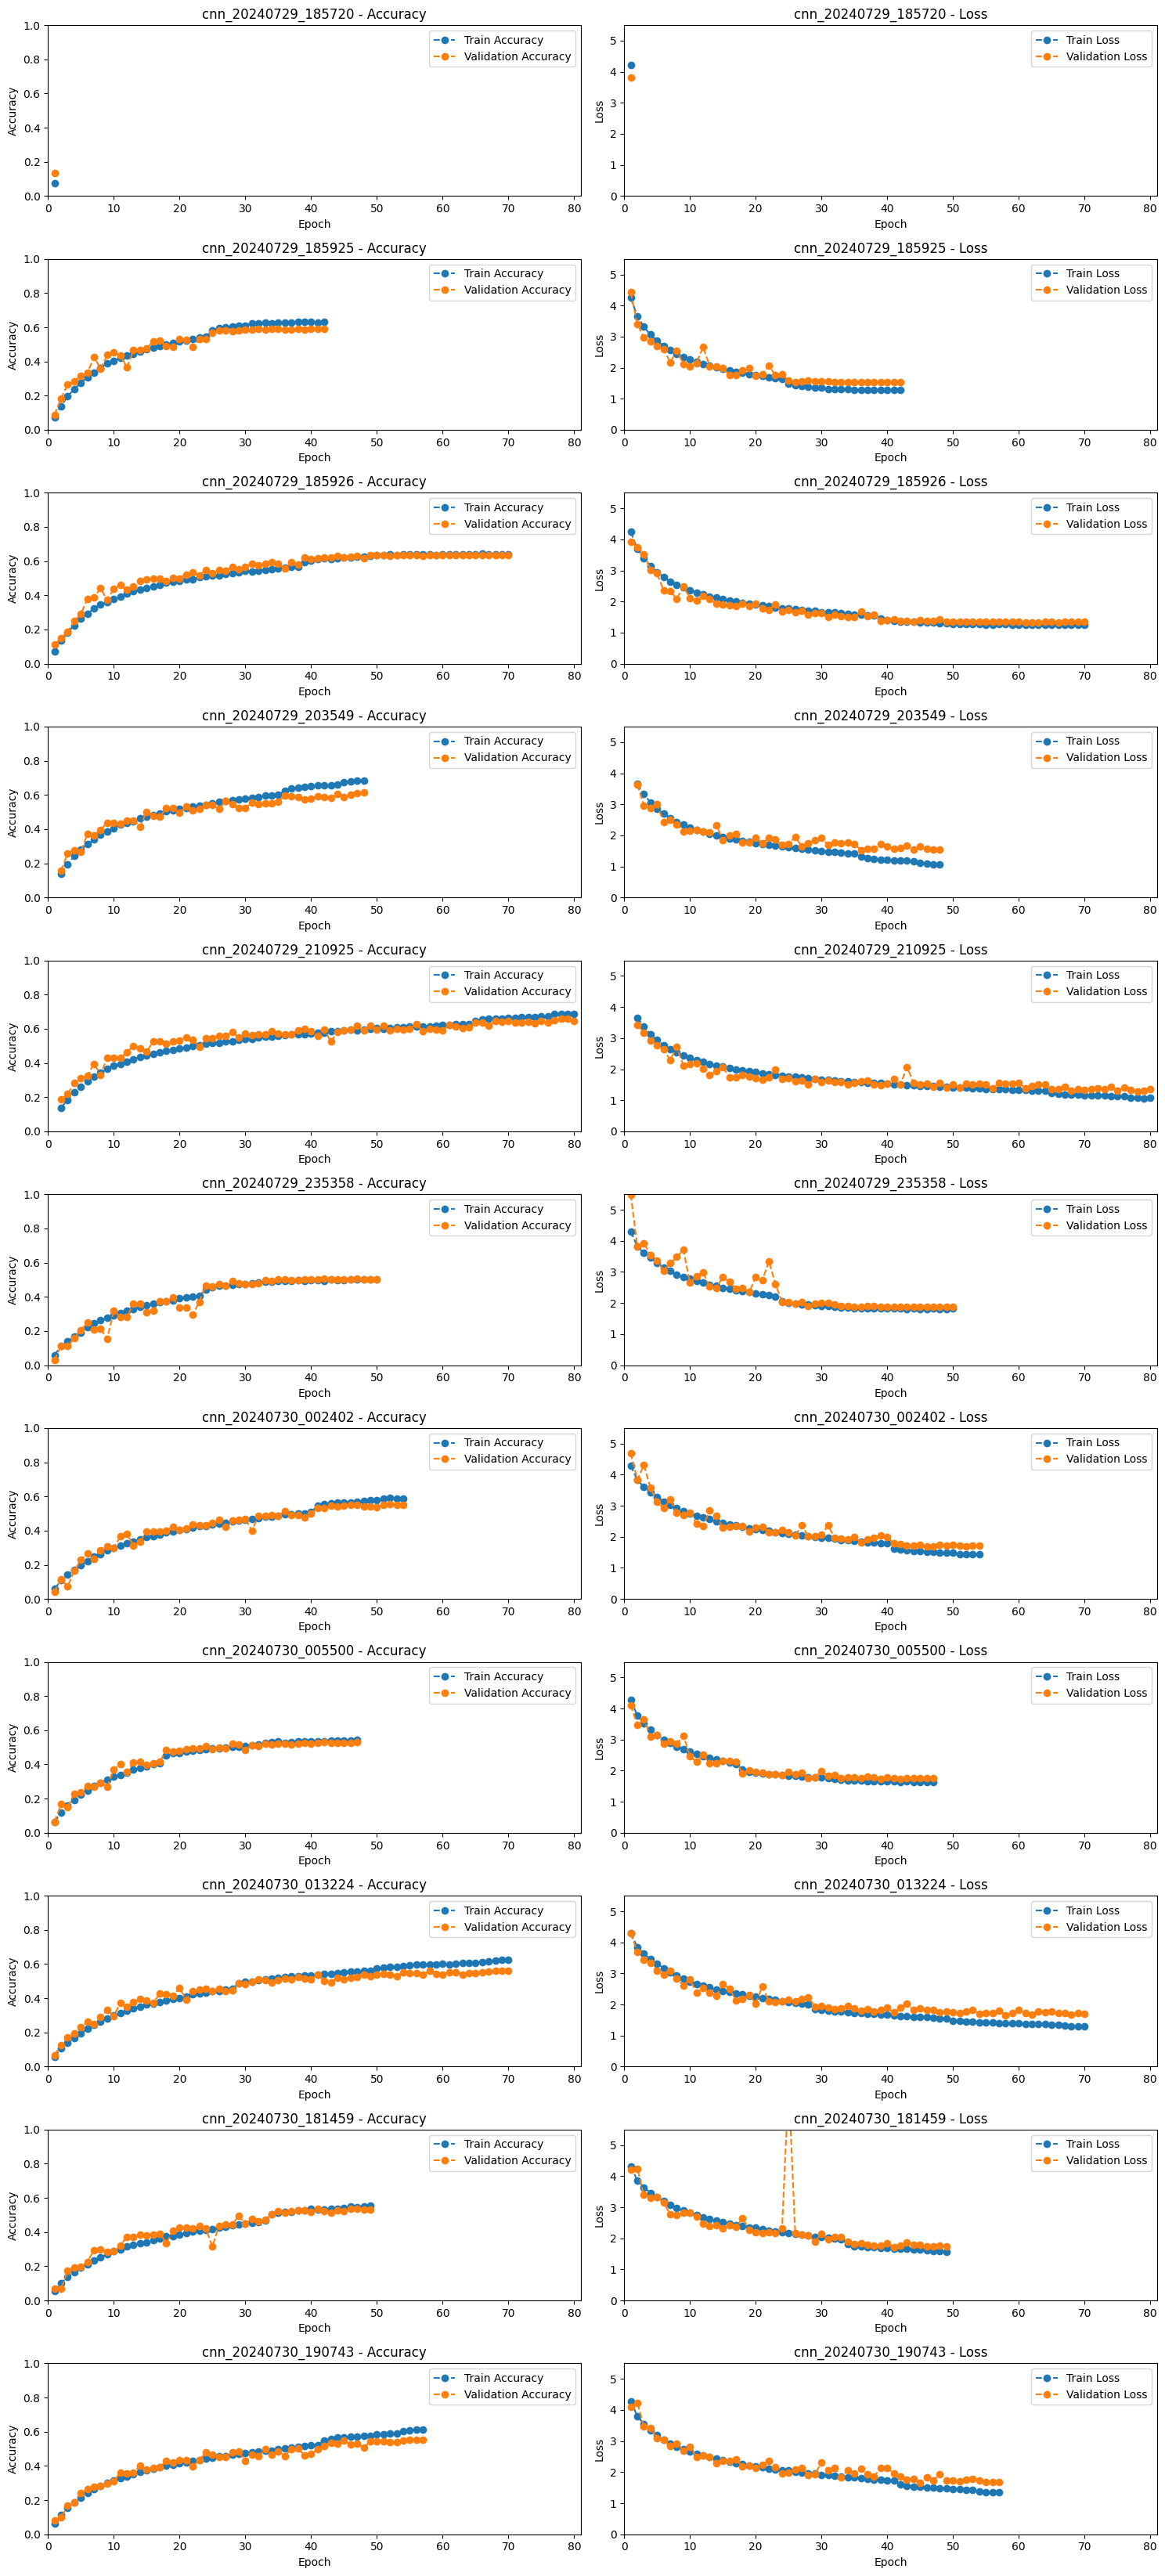

In [ ]:
# Load the CSV data
model_performance = pd.read_csv('/content/drive/MyDrive/cifar100/model_performance2.csv')





# Define the list of models to include
#selected_models = ['cnn_20240311_225534', 'cnn_20240311_183413', 'cifar100_57accur']
selected_models = model_performance['model_id'].unique() #select all models

# Find the maximum number of epochs across all models
max_epochs = model_performance['epoch'].max() + 1

# Create subplots
fig, axs = plt.subplots(len(selected_models), 2, figsize=(15, 3 * len(selected_models)))


# Plot accuracy and loss for each model
for i, model_id in enumerate(selected_models):
    model_data = model_performance[model_performance['model_id'] == model_id]

    # Plot Accuracy
    axs[i, 0].plot(model_data['epoch'], model_data['accuracy'], label='Train Accuracy', linestyle='--', marker='o')
    axs[i, 0].plot(model_data['epoch'], model_data['val_accuracy'], label='Validation Accuracy', linestyle='--', marker='o')
    axs[i, 0].set_title(f'{model_id} - Accuracy')
    axs[i, 0].set_xlabel('Epoch')
    axs[i, 0].set_ylabel('Accuracy')
    axs[i, 0].set_ylim([0, 1])
    axs[i, 0].legend()

    # Plot Loss
    axs[i, 1].plot(model_data['epoch'], model_data['loss'], label='Train Loss', linestyle='--', marker='o')
    axs[i, 1].plot(model_data['epoch'], model_data['val_loss'], label='Validation Loss', linestyle='--', marker='o')
    axs[i, 1].set_title(f'{model_id} - Loss')
    axs[i, 1].set_xlabel('Epoch')
    axs[i, 1].set_ylabel('Loss')
    axs[i, 1].set_ylim([0, 5.5])
    axs[i, 1].legend()

    # Set x-axis limits to match the plot with the most epochs
    axs[i, 0].set_xlim([0, max_epochs])
    axs[i, 1].set_xlim([0, max_epochs])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Load and display model summaries
for model in selected_models:
    get_model = load_model(f'/content/drive/MyDrive/cifar100/src/models/model_{model}.h5')
    print(model)
    get_model.summary()
    print('\n', '#' * 80, '\n')